# H2O Automated Machine Learning (AutoML)

## 0 Introduction
The objective of this notbook is to use to data generated from the previous notebooks to carry out Automated Machine Learning (AutoML) and captrure the important features at the underlying structure of signal peptides. In order to achieve this, the predictions of SignalP algorithm will be merged with the observations of Proteomics results obtained from the previous two notebooks, respectively. This will enable the observed signal peptides to be assigned with peptide abundance, while keeping the predicted signal peptides at zero abundance, thus generating a dataframe that emphasizes importance of signal peptides through the peptide abundance. 

### Agenda
- Generate dataframe for AutoML
- Utilize AutoML to carry out ML operations
- Determine the best AutoML model generated
- Analyze the best model parameters 
- Check AutoML prediction based on the best model

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import drive 
drive.mount('/content/home')

Mounted at /content/home


In [3]:
# Load the dataframe generated in the previous notebook for AutoML operations
df_signalPP = pd.read_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/ML_signal_peptides.csv')
df_signalPP

,sequence,length,abundance
0,MMVAWWSLFLYGLQVAAPAL,20,1.000000
1,MEAFNLHNFLSSLYILLPFVILANPVH,27,0.417923
2,MLRVSAIFMACLLLATAA,18,0.339312
3,MAVRIARFLGLSTVAYLALANGID,24,0.276919
4,MVSFSSCLRALALGSSVLAVQPVL,24,0.218331
...,...,...,...
1056,MQVKLFYTLALWAPILVS,18,0.000000
1057,MKSLIWALPFIPLAY,15,0.000000
1058,MWPTRSLSSLFFLSLALGSPVS,22,0.000000
1059,MLLPRLSSLLCLAGLATMPVAN,22,0.000000


In [4]:
def split_peptides_sequences(df_signalPP:pd.DataFrame): 
    '''Split each AA for each position'''
    peptides_split = []
    for k,v in df_signalPP.iterrows(): 
        sequence = []
        for seq in v['sequence']: 
            sequence.append(seq)
        peptides_split.append(sequence)
    
    # make a dataframe
    new_peptides = pd.DataFrame(peptides_split)
    new_peptides = new_peptides.fillna('-')

    return new_peptides

In [5]:
df_signalPP_split = split_peptides_sequences(df_signalPP)
df_signalPP_split

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,M,M,V,A,W,W,S,L,F,L,...,-,-,-,-,-,-,-,-,-,-
1,M,E,A,F,N,L,H,N,F,L,...,-,-,-,-,-,-,-,-,-,-
2,M,L,R,V,S,A,I,F,M,A,...,-,-,-,-,-,-,-,-,-,-
3,M,A,V,R,I,A,R,F,L,G,...,-,-,-,-,-,-,-,-,-,-
4,M,V,S,F,S,S,C,L,R,A,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,M,Q,V,K,L,F,Y,T,L,A,...,-,-,-,-,-,-,-,-,-,-
1057,M,K,S,L,I,W,A,L,P,F,...,-,-,-,-,-,-,-,-,-,-
1058,M,W,P,T,R,S,L,S,S,L,...,-,-,-,-,-,-,-,-,-,-
1059,M,L,L,P,R,L,S,S,L,L,...,-,-,-,-,-,-,-,-,-,-


In [6]:
# Merge the experimental abundances with the split dataframe
df_signalPP_split['abundance'] = df_signalPP['abundance']
df_signalPP_split

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,abundance
0,M,M,V,A,W,W,S,L,F,L,...,-,-,-,-,-,-,-,-,-,1.000000
1,M,E,A,F,N,L,H,N,F,L,...,-,-,-,-,-,-,-,-,-,0.417923
2,M,L,R,V,S,A,I,F,M,A,...,-,-,-,-,-,-,-,-,-,0.339312
3,M,A,V,R,I,A,R,F,L,G,...,-,-,-,-,-,-,-,-,-,0.276919
4,M,V,S,F,S,S,C,L,R,A,...,-,-,-,-,-,-,-,-,-,0.218331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,M,Q,V,K,L,F,Y,T,L,A,...,-,-,-,-,-,-,-,-,-,0.000000
1057,M,K,S,L,I,W,A,L,P,F,...,-,-,-,-,-,-,-,-,-,0.000000
1058,M,W,P,T,R,S,L,S,S,L,...,-,-,-,-,-,-,-,-,-,0.000000
1059,M,L,L,P,R,L,S,S,L,L,...,-,-,-,-,-,-,-,-,-,0.000000


## 3 H2O AutoML

In [7]:
# Install H2O
%%capture 
!pip install h2o

In [8]:
# Import the required packages for H2O AutoML operations 
import h2o
from h2o.automl import H2OAutoML

In [9]:
# Initiate H2O
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuis980tm
  JVM stdout: /tmp/tmpuis980tm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuis980tm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unknownUser_1e35l3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [10]:
# Convert the split dataframe into H2O datafame (H2OFrame)
df_test = h2o.H2OFrame(df_signalPP_split)
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:1061
Cols:69

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,abundance
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,int,enum,int,int,int,int,int,int,int,real
mins,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,,,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,,,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003157757935910452
maxs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,,,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
sigma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,,,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03730967489556199
zeros,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1056,,,1057,,1059,1059,1059,1060,1060,1060,1060,819
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,4,0,2,2,2,1,1,1,1,0
0,M,M,V,A,W,W,S,L,F,L,Y,G,L,Q,V,A,A,P,A,L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,M,E,A,F,N,L,H,N,F,L,S,S,L,Y,I,L,L,P,F,V,I,L,A,N,P,V,H,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4179234540632222
2,M,L,R,V,S,A,I,F,M,A,C,L,L,L,A,T,A,A,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339312307761118


In [11]:
for column in df_test.columns:
    if column != 'abundance':
        df_test[column] = df_test[column].asfactor()

In [12]:
df_test.describe()

Rows:1061
Cols:69

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,abundance
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real
mins,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0
mean,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.003157757935910452
maxs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.0
sigma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.03730967489556199
zeros,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,819
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,4,0,2,2,2,1,1,1,1,0
0,M,M,V,A,W,W,S,L,F,L,Y,G,L,Q,V,A,A,P,A,L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-,-,0,-,0,0,0,0,0,0,0,1.0
1,M,E,A,F,N,L,H,N,F,L,S,S,L,Y,I,L,L,P,F,V,I,L,A,N,P,V,H,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-,-,0,-,0,0,0,0,0,0,0,0.4179234540632222
2,M,L,R,V,S,A,I,F,M,A,C,L,L,L,A,T,A,A,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-,-,0,-,0,0,0,0,0,0,0,0.339312307761118


## 4 AutoML model analysis

In [13]:
# Specify the directory path where the models are stored
model_dir = "/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/06.1_Best_models/"

# Load each model in the directory
models = []
for file_name in os.listdir(model_dir):
    if file_name.endswith(".model"):
        model_path = os.path.join(model_dir, file_name)
        model = h2o.load_model(model_path)
        models.append(model)
        print(model.model_id)

DeepLearning_grid_2_AutoML_2_20230303_104051_model_1
DRF_1_AutoML_2_20230303_104057
DeepLearning_grid_2_AutoML_1_20230228_161212_model_2
DeepLearning_grid_3_AutoML_1_20230301_70608_model_1
DRF_1_AutoML_1_20230301_174301
DeepLearning_grid_1_AutoML_1_20230301_192101_model_6
GBM_grid_1_AutoML_1_20230301_90248_model_68
GBM_grid_1_AutoML_2_20230220_183307_model_68
GBM_grid_1_AutoML_3_20230222_84759_model_68
DeepLearning_grid_1_AutoML_1_20230302_174841_model_3
DRF_1_AutoML_1_20230220_170537
DRF_1_AutoML_1_20230226_191517
DeepLearning_grid_1_AutoML_1_20230301_174230_model_2
DeepLearning_grid_1_AutoML_1_20230301_192304_model_13
DeepLearning_grid_1_AutoML_2_20230222_74710_model_5
DeepLearning_grid_1_AutoML_2_20230302_191152_model_2
DeepLearning_grid_2_AutoML_2_20230226_203543_model_3
DeepLearning_grid_2_AutoML_1_20230227_93706_model_1
DeepLearning_grid_1_AutoML_1_20230220_202914_model_6
DeepLearning_grid_1_AutoML_1_20230222_104619_model_1


In [14]:
# Create an empty pandas DataFrame
df = pd.DataFrame(columns=['Model', 'MAE'])

# Iterate through the list of loaded models and extract their name and MAE metric value
for i, model in enumerate(models):
    mae = model.mae()
    # model_name = model.model_id.split('_')[0] # extract model name before "_"
    model_name = model.model_id
    df.loc[i] = [model_name, mae]

# Sort the DataFrame by 'MAE' column in descending order
df_sorted = df.sort_values(by=['MAE'], ascending=False)

# Reset the indexing of the DataFrame
df_sorted = df_sorted.reset_index(drop=True)

# Print the pandas DataFrame
print(df_sorted)

                                                Model       MAE
0   DeepLearning_grid_2_AutoML_2_20230226_203543_m...  8.400805
1   DeepLearning_grid_2_AutoML_1_20230228_161212_m...  0.021801
2   DeepLearning_grid_3_AutoML_1_20230301_70608_mo...  0.013645
3                      DRF_1_AutoML_2_20230303_104057  0.005758
4         GBM_grid_1_AutoML_1_20230301_90248_model_68  0.005481
5        GBM_grid_1_AutoML_2_20230220_183307_model_68  0.005481
6         GBM_grid_1_AutoML_3_20230222_84759_model_68  0.005481
7                      DRF_1_AutoML_1_20230220_170537  0.005298
8                      DRF_1_AutoML_1_20230226_191517  0.005298
9   DeepLearning_grid_2_AutoML_1_20230227_93706_mo...  0.005014
10                     DRF_1_AutoML_1_20230301_174301  0.004988
11  DeepLearning_grid_2_AutoML_2_20230303_104051_m...  0.003959
12  DeepLearning_grid_1_AutoML_1_20230222_104619_m...  0.003809
13  DeepLearning_grid_1_AutoML_1_20230220_202914_m...  0.003339
14  DeepLearning_grid_1_AutoML_1_2023030

In [15]:
# Print the model statistics
print(models[0])

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_2_20230303_104051_model_1


Status of Neuron Layers: predicting abundance, regression, gaussian distribution, Quadratic loss, 53,301 weights/biases, 633.9 KB, 130,711 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  -------------------  --------------------  -----------------------
    1        430      Input             15.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.23276296097730462    0.24834179878234863   0.0         0.002958147068917464  0.06376025080680847  0.7357743606181819    0.5684988498687744
    3        100      RectifierDropout  10.0       0

In [49]:
# Retrieve model performance
bm_performance = models[0].model_performance()
print(bm_performance)

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.0016584398069097528
RMSE: 0.040723946357269364
MAE: 0.005297624901332574
RMSLE: 0.0315349957378654
Mean Residual Deviance: 0.0016584398069097528


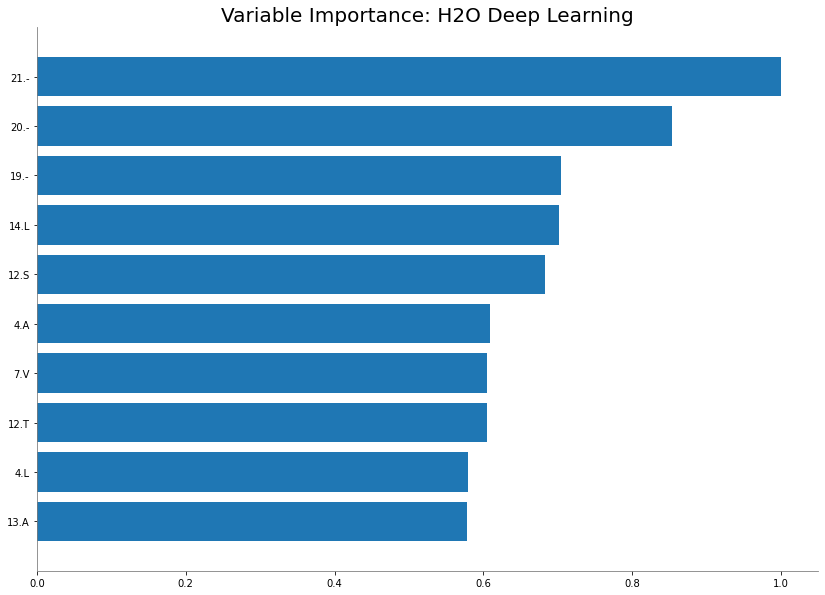

<Figure size 432x288 with 0 Axes>

In [17]:
models[0].varimp_plot()

In [19]:
# Retrieve the stored cross-validation (cv) holdout predictions
cv_hold_predictions = models[0].predict(df_test).as_data_frame()
cv_hold_predictions

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '12' has levels not trained on: ["K"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '20' has levels not trained on: ["F"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '21' has levels not trained on: ["M"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '6' has levels not trained on: ["D"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '3' has levels not trained on: ["D"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column '5' has levels not trained on: ["E"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/V

,predict
0,0.030347
1,0.002110
2,0.019608
3,0.001763
4,0.001160
...,...
1056,0.001735
1057,0.001149
1058,0.001149
1059,0.001904


In [ ]:
# Convert df_test into a dataframe
df_test_as_df = df_test.as_data_frame()
df_test_as_df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,abundance
0,M,M,V,A,W,W,S,L,F,L,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,M,E,A,F,N,L,H,N,F,L,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417923
2,M,L,R,V,S,A,I,F,M,A,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339312
3,M,A,V,R,I,A,R,F,L,G,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276919
4,M,V,S,F,S,S,C,L,R,A,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,M,Q,V,K,L,F,Y,T,L,A,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1057,M,K,S,L,I,W,A,L,P,F,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1058,M,W,P,T,R,S,L,S,S,L,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1059,M,L,L,P,R,L,S,S,L,L,...,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# Merge the cv holdout predictions together with the df_test abundance
df_signalP_cv_holdout = pd.merge(df_test_as_df, cv_hold_predictions, left_index=True, right_index=True)

# Order the dataframe in the descending order of abundance values
df_signalP_cv_holdout = df_signalP_cv_holdout.sort_values(by= 'abundance', ascending = False)

# Rename the predict column
df_signalP_cv_holdout = df_signalP_cv_holdout.rename(columns={'predict': 'cv_hold_predictions'})

# Reset the indexing of the dataframe
df_signalP_cv_holdout = df_signalP_cv_holdout.reset_index()


In [ ]:
# Generate percentage ranking of the abundance and cv_predictions 
df_signalP_cv_holdout['abundance_ranked_pct'] = df_signalP_cv_holdout['abundance'].rank(pct=True)
df_signalP_cv_holdout['cv_ranked_pct'] = df_signalP_cv_holdout['cv_hold_predictions'].rank(pct=True)
df_signalP_cv_holdout

,index,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,abundance,cv_hold_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,M,M,V,A,W,W,S,L,F,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.303491,1.000000,0.999057
1,1,M,E,A,F,N,L,H,N,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.417923,0.266148,0.999057,0.997172
2,2,M,L,R,V,S,A,I,F,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.339312,0.220121,0.998115,0.996230
3,3,M,A,V,R,I,A,R,F,L,...,0.0,0.0,0.0,0.0,0.0,0.0,0.276919,0.172186,0.997172,0.995287
4,4,M,V,S,F,S,S,C,L,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.218331,0.141672,0.996230,0.994345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,515,M,L,P,N,L,G,I,L,I,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000066,0.386428,0.423186
1057,516,M,K,I,A,S,I,S,A,I,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002123,0.386428,0.899152
1058,517,M,S,D,T,V,Q,K,L,C,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000073,0.386428,0.450518
1059,518,M,S,F,S,K,V,A,I,V,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000142,0.386428,0.566447


In [ ]:
# Save the dataframe
df_signalP_cv_holdout.to_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/06.3_Cv_holdout_predictions/First_round/m22_GBM_grid_1_90248_cv_hold_predictions.csv')

## 5 Visualization of AutoML model

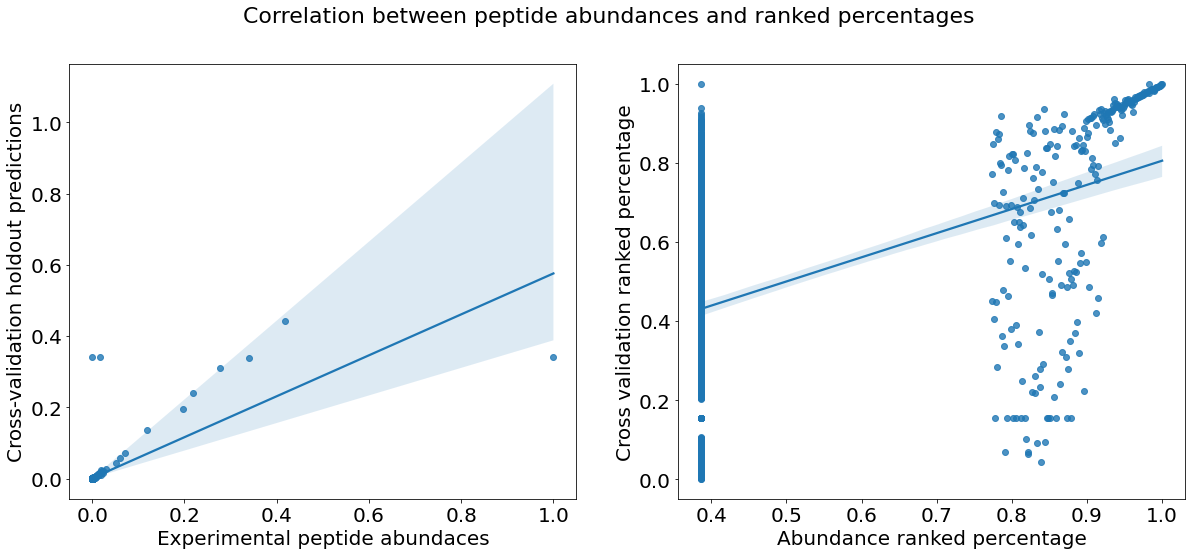

In [ ]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [ ]:
# Drop rows where NaN values of the peptide abundance was set to 0 to reduce noise (i.e. create a dataframe without (wo) NaN/zero values)
df_signalP_cv_holdout_wo_NaNs = df_signalP_cv_holdout[df_signalP_cv_holdout['abundance'] != 0]
df_signalP_cv_holdout_wo_NaNs

,index,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,abundance,cv_hold_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,M,M,V,A,W,W,S,L,F,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.342243,1.000000,0.998115
1,1,M,E,A,F,N,L,H,N,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.417923,0.443007,0.999057,1.000000
2,2,M,L,R,V,S,A,I,F,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.339312,0.338367,0.998115,0.996230
3,3,M,A,V,R,I,A,R,F,L,...,0.0,0.0,0.0,0.0,0.0,0.0,0.276919,0.309445,0.997172,0.995287
4,4,M,V,S,F,S,S,C,L,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.218331,0.239212,0.996230,0.994345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,237,M,R,G,L,L,L,A,G,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.000062,0.776626,0.406221
238,249,M,K,V,T,K,K,V,L,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.000233,0.775683,0.697455
239,202,M,H,V,L,S,T,L,T,Q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.000423,0.774741,0.848256
240,117,M,R,V,Q,A,F,I,F,V,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.000084,0.773327,0.451461


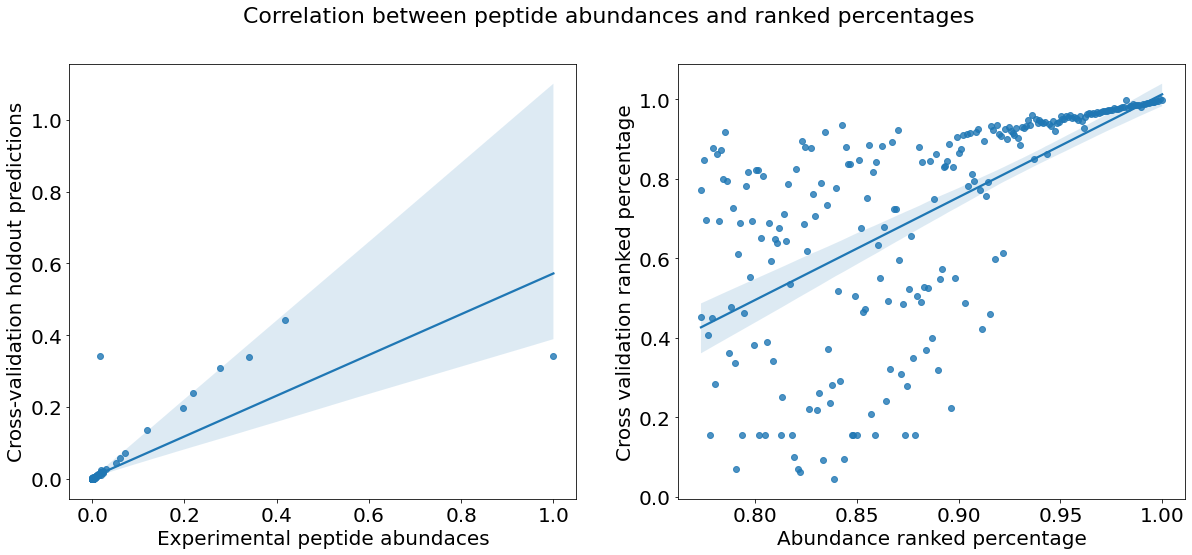

In [ ]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [ ]:
# Save the resulting dataframe
df_signalP_cv_holdout_wo_NaNs.to_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/cv_hold_ranked_pct_m22_GBM_grid_1.csv', index=False)